## Automate the ML process using pipelines 

There are standard workflows in a machine learning project that can be automated. In Python scikit-learn, Pipelines help to clearly define and automate these workflows.
* Pipelines help overcome common problems like data leakage in your test harness. 
* Python scikit-learn provides a Pipeline utility to help automate machine learning workflows.
* Pipelines work by allowing for a linear sequence of data transforms to be chained together culminating in a modeling process that can be evaluated.

### Data Preparation and Modeling Pipeline

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create a pipeline that standardizes the data then creates a model
#Load libraries for data processing
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from scipy.stats import norm

from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# visualization
import seaborn as sns 
plt.style.use('fivethirtyeight')
sns.set_style("white")

plt.rcParams['figure.figsize'] = (8,4) 
plt.rcParams['axes.titlesize'] = 'large'



### Evaluate Some Algorithms
Now it is time to create some models of the data and estimate their accuracy on unseen data. Here is what we are going to cover in this step:
1. Separate out a validation dataset.
2. Setup the test harness to use 10-fold cross validation.
3. Build 5 different models  
4. Select the best model

## 1.0 Validation Dataset

In [84]:
#load data
data = pd.read_csv('data/clean-data.csv', index_col=False)
data.drop('Unnamed: 0',axis=1, inplace=True)

# Split-out validation dataset
array = data.values
X = array[:,1:31]
y = array[:,0]

# Divide records in training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

#transform the class labels from their original string representation (M and B) into integers
le = LabelEncoder()
y = le.fit_transform(y)

## 2.0 Evaluate Algorithms: Baseline

c:\Users\Jad Zoghaib\Downloads\micromamba\envs\breastcancer\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Jad Zoghaib\Downloads\micromamba\envs\breastcancer\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

LR: 0.9549 (0.0331)
LDA: 0.9547 (0.0188)
KNN: 0.9372 (0.0282)
CART: 0.9271 (0.0454)
NB: 0.9371 (0.0408)
SVM: 0.9020 (0.0470)

-> 10-Fold cross-validation accuracy score for the training data across six classifiers

KNN: 0.9372 (0.0282)
CART: 0.9271 (0.0454)
NB: 0.9371 (0.0408)
SVM: 0.9020 (0.0470)

-> 10-Fold cross-validation accuracy score for the training data across six classifiers



C:\Users\Jad Zoghaib\AppData\Local\Temp\ipykernel_37892\2279512232.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names)


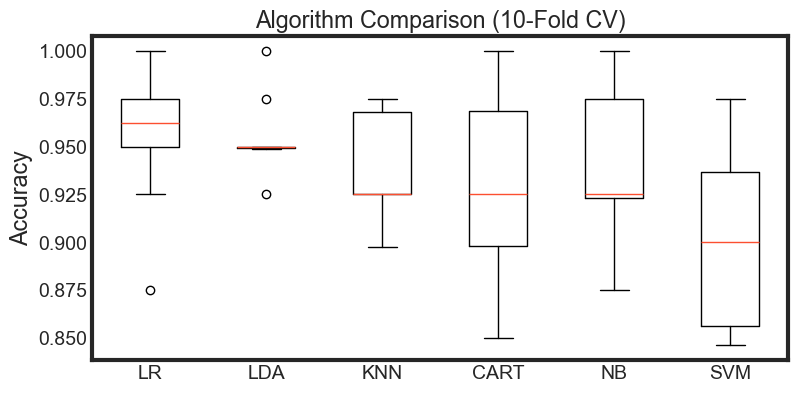

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt



# Define models (no duplicates)
models = [
    ('LR', LogisticRegression(max_iter=1000)),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(random_state=7)),
    ('NB', GaussianNB()),
    ('SVM', SVC())
]

# Cross-validation settings
num_folds = 10
seed = 7
scoring = 'accuracy'

results = []
names = []

# Build cross-validator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Run evaluation
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)

    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

print("\n-> 10-Fold cross-validation accuracy score for the training data across six classifiers\n")




plt.boxplot(results, labels=names)
plt.title("Algorithm Comparison (10-Fold CV)")
plt.ylabel("Accuracy")
plt.show()



In [86]:
len(X_train)

398

#### Observation
> The results suggest That both Logistic Regression and LDA may be worth further study. These are just mean accuracy values. It is always wise to look at the distribution of accuracy values calculated across cross validation folds. We can do that graphically using box and whisker plots.


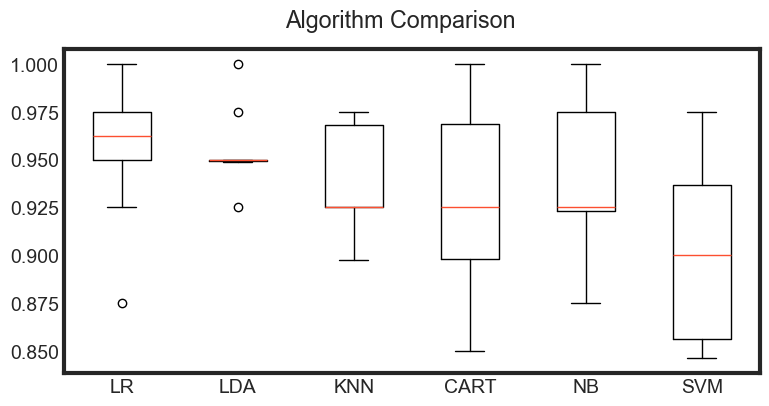

In [87]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison' )
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Observation
> The results show a similar tight distribution for all classifiers except SVM which is encouraging, suggesting low variance. The poor results for SVM are surprising.

> It is possible the varied distribution of the attributes may have an effect on the accuracy of algorithms such as SVM. In the next section we will repeat this spot-check with a standardized copy of the training dataset.


### 2.1 Evaluate Algorithms: Standardize Data

In [88]:
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),( 'LR' ,
    LogisticRegression())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),( 'LDA' ,
    LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledKNN' , Pipeline([( 'Scaler' , StandardScaler()),( 'KNN' ,
    KNeighborsClassifier())])))
pipelines.append(( 'ScaledCART' , Pipeline([( 'Scaler' , StandardScaler()),( 'CART' ,
    DecisionTreeClassifier())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),( 'NB' ,
    GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),( 'SVM' , SVC())])))

results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)


  cv_results = cross_val_score(model, X_train, y_train, cv=kfold,
      scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledLR: 0.974936 (0.015813)
ScaledLDA: 0.954744 (0.018784)
ScaledKNN: 0.957372 (0.033665)
ScaledCART: 0.924808 (0.044580)
ScaledNB: 0.937115 (0.039261)
ScaledSVM: 0.967436 (0.027483)
ScaledCART: 0.924808 (0.044580)
ScaledNB: 0.937115 (0.039261)
ScaledSVM: 0.967436 (0.027483)


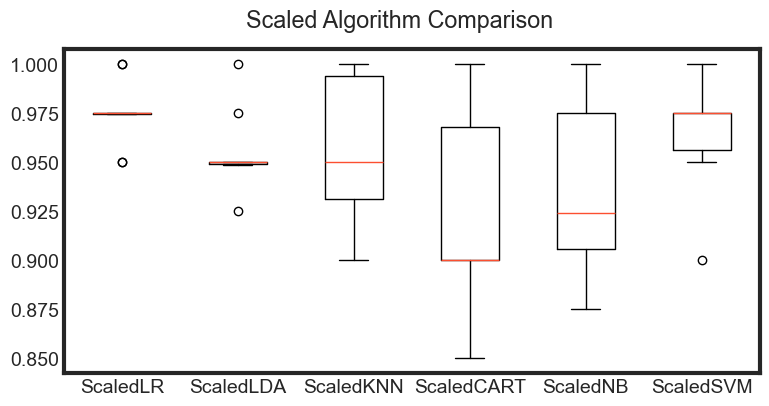

In [89]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle( 'Scaled Algorithm Comparison' )
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Observations
> The results show that standardization of the data has lifted the skill of SVM to be the most accurate algorithm tested so far.

The results suggest digging deeper into the SVM and LDA and LR algorithms. It is very likely that configuration beyond the default may yield even more accurate models.

## 3.0 Algorithm Tuning
In this section we investigate tuning the parameters for three algorithms that show promise from the spot-checking in the previous section: LR, LDA and SVM.

### Tuning hyper-parameters - SVC estimator

In [90]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV

# Make Support Vector Classifier Pipeline
pipe_svc = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('clf', SVC(probability=True, verbose=False))
])

# Fit Pipeline to training data
pipe_svc.fit(X_train, y_train)

# Evaluate with cross-validation
scores = cross_val_score(estimator=pipe_svc, X=X_train, y=y_train, cv=10, n_jobs=1)
print('--> Model Training Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# Tune Hyperparameters
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'clf__C': param_range, 'clf__kernel': ['linear']},
    {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}
]

gs_svc = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    n_jobs=1
)

# Fit GridSearch to find best hyperparameters
gs_svc.fit(X_train, y_train)

# Print results
print('--> Tuned Parameters Best Score: %.3f' % gs_svc.best_score_)
print('--> Best Parameters: ', gs_svc.best_params_)


--> Model Training Accuracy: 0.940 +/- 0.034
--> Tuned Parameters Best Score: 0.945
--> Best Parameters:  {'clf__C': 1.0, 'clf__kernel': 'linear'}
--> Tuned Parameters Best Score: 0.945
--> Best Parameters:  {'clf__C': 1.0, 'clf__kernel': 'linear'}


### Tuning the hyper-parameters - k-NN hyperparameters
 For your standard k-NN implementation, there are two primary hyperparameters that you’ll want to tune:

* The number of neighbors k.
* The distance metric/similarity function.

Both of these values can dramatically affect the accuracy of your k-NN classifier. Grid object is ready to do 10-fold cross validation on a KNN model using classification accuracy as the evaluation metric
In addition, there is a parameter grid to repeat the 10-fold cross validation process 30 times
Each time, the n_neighbors parameter should be given a different value from the list
We can't give GridSearchCV just a list
We've to specify n_neighbors should take on 1 through 30
You can set n_jobs = -1 to run computations in parallel (if supported by your computer and OS) 

In [91]:
from sklearn.neighbors import KNeighborsClassifier as KNN

pipe_knn = Pipeline([('scl', StandardScaler()),
                     ('pca', PCA(n_components=2)),
                     ('clf', KNeighborsClassifier())])
            
#Fit Pipeline to training Data
pipe_knn.fit(X_train, y_train) 

scores = cross_val_score(estimator=pipe_knn, 
                         X=X_train, 
                         y=y_train, 
                         cv=10,
                         n_jobs=1)
print('--> Model Training Accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

#Tune Hyperparameters
param_range = range(1, 31)
param_grid = [{'clf__n_neighbors': param_range}]
# instantiate the grid
grid = GridSearchCV(estimator=pipe_knn, 
                    param_grid=param_grid, 
                    cv=10, 
                    scoring='accuracy')
gs_knn = grid.fit(X_train, y_train)
print('--> Tuned Parameters Best Score: ',gs_knn.best_score_)
print('--> Best Parameters: \n',gs_knn.best_params_)

--> Model Training Accuracy: 0.927 +/- 0.044
--> Tuned Parameters Best Score:  0.9396153846153847
--> Best Parameters: 
 {'clf__n_neighbors': 19}
--> Tuned Parameters Best Score:  0.9396153846153847
--> Best Parameters: 
 {'clf__n_neighbors': 19}


### Finalize Model

In [92]:
#Use best parameters
clf_svc = gs_svc.best_estimator_

#Get Final Scores
clf_svc.fit(X_train, y_train)
scores = cross_val_score(estimator=clf_svc,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('--> Final Model Training Accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

print('--> Final Accuracy on Test set: %.5f' % clf_svc.score(X_test,y_test))


--> Final Model Training Accuracy: 0.945 +/- 0.041
--> Final Accuracy on Test set: 0.97076
